In [1]:
import polars as pl
import jax
from jax import numpy as jnp
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
import numpy as np
import arviz as az

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

# Data Setup


In [2]:
ped_accidents_df = pl.read_csv("./data/ped_accident_df.csv")


In [54]:
ped_accidents_df["ALCOHOLNAME"].value_counts(normalize=True)

ALCOHOLNAME,proportion
str,f64
null,0.64388
"""Reported as Unknown""",0.189067
"""Alcohol Involved""",0.019275
"""No Alcohol Involved""",0.147778


## Safety Features

In [3]:
safety_features = ped_accidents_df[
    # "PEDESTRIANAUTOEMERGENCYBRAKINGID",
    "PEDESTRIANAUTOEMERGENCYBRAKING",
    "BLINDSPOTWARNING",
    "BLINDSPOTINTERVENTION",
    "LANEDEPARTUREWARNING",
    "LANEKEEPINGASSISTANCE",
    "LANECENTERINGASSISTANCE",
    "BACKUPCAMERA",
    "REARCROSSTRAFFICALERT",
    "REARAUTOMATICEMERGENCYBRAKING",
    # "DAYTIMERUNNINGLIGHT",
    # "HEADLAMPLIGHTSOURCE",
    # "SEMIAUTOHEADLAMPBEAMSWITCHING",
    "ADAPTIVEDRIVINGBEAM",
    # "ADAPTIVECRUISECONTROL",
    "ANTILOCKBRAKESYSTEM",
    "ELECTRONICSTABILITYCONTROL",
    # "TPMS",
    # "AUTOMATICCRASHNOTIFICATION",
    # "EVENTDATARECORDER",
    "TRACTIONCONTROL",
    "AUTOPEDESTRIANALERTINGSOUND",
    "ACTIVESAFETYSYSNOTE",
]

for col in safety_features.columns:
    print(ped_accidents_df[col].value_counts())

shape: (4, 2)
┌────────────────────────────────┬───────┐
│ PEDESTRIANAUTOEMERGENCYBRAKING ┆ count │
│ ---                            ┆ ---   │
│ str                            ┆ u32   │
╞════════════════════════════════╪═══════╡
│ Not Available                  ┆ 8     │
│ null                           ┆ 8575  │
│ Standard                       ┆ 774   │
│ Optional                       ┆ 137   │
└────────────────────────────────┴───────┘
shape: (4, 2)
┌──────────────────┬───────┐
│ BLINDSPOTWARNING ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ Not Available    ┆ 3     │
│ null             ┆ 8142  │
│ Optional         ┆ 533   │
│ Standard         ┆ 816   │
└──────────────────┴───────┘
shape: (3, 2)
┌───────────────────────┬───────┐
│ BLINDSPOTINTERVENTION ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ Standard              ┆ 58    │
│ Optional              ┆ 21    │


Among these, we suspect that that lane departure warning, lane centering assistance, adaptive driving beam, headlamp light source, pedestrian alerting sounds, and traction control
may have a realistic impact specifically on either pedestrian or cyclist crashes, and so they will be our target focus. We will also include an indicator for whether or not a particular
vehicle had any sort of extra notes in the active safety system, as we think *a priori* this may be associated with more expensive/safer cars.

However, we have to make some simplifying assumptions, namely that these safety features, if they are not listed, are missing. This is very conservative, and in fact, it would be 
better to impute these features acording to some probabilistic estimate. 

In [4]:
imputed_safety_features = (safety_features == "Standard").fill_null(False)

## Controls

In [5]:
# [print(c) for c in ped_accidents_df["BIKECGPNAME"].value_counts()["BIKECGPNAME"]]
# [print(c) for c in ped_accidents_df["PEDCGPNAME"].value_counts()["PEDCGPNAME"]]


# https://gist.githubusercontent.com/rogerallen/1583593/raw/2dd598547e1a5680740ebf3d4365f628c1951579/us_state_abbrev.py
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands, U.S.": "VI",
}

region_int_map = {
    "1": "Northeast",
    "2": "Midwest",
    "3": "South",
    "4": "West"
}


def map_region(abbrev):
    # REGIONS - per CRSS documentation
    # 1 Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)
    # 2 Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)
    # 3 South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)
    # 4 West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI
    if abbrev is None:
        return None
    elif abbrev in set(["PA", "NJ", "NY", "NH", "VT", "RI", "MA", "ME", "CT"]):
        return "1"
    elif abbrev in set(
        ["OH", "IN", "IL", "MI", "WI", "MN", "ND", "SD", "NE", "IA", "MO", "KS"]
    ):
        return "2"
    elif abbrev in set(
        [
            "MD",
            "DE",
            "DC",
            "WV",
            "VA",
            "KY",
            "TN",
            "NC",
            "SC",
            "GA",
            "FL",
            "AL",
            "MS",
            "LA",
            "AR",
            "OK",
            "TX",
        ]
    ):
        return "3"
    else:
        return "4"


In [6]:
[print(c) for c in ped_accidents_df[["BODYCLASS"]].unique()["BODYCLASS"]]

vans = [
    "Van",
    "Cargo Van",
]
big_vehicles = [
    "Incomplete - Chassis Cab (Single Cab)",
    "Truck-Tractor",
    "Truck",
    "Bus",
]
cars = [
    "Hatchback/Liftback/Notchback",
    "Sedan/Saloon",
    "Coupe",
    "Convertible/Cabriolet",
]



Convertible/Cabriolet
Truck-Tractor
Truck
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)
Cargo Van
Coupe
Van
Bus
Crossover Utility Vehicle (CUV)
Minivan
Pickup
Hatchback/Liftback/Notchback
Sedan/Saloon
Incomplete - Chassis Cab (Single Cab)


In [7]:
controls_df = (
    ped_accidents_df.with_columns(
        # pl.coalesce(
        pl.col("BIKECGPNAME").replace("Not a Cyclist", None).alias("BIKECGP_new"),
        pl.col("PEDCGPNAME").replace("Not a Pedestrian", None).alias("PEDCGP_new"),
    )
    .with_columns(
        # crash groups combined
        pl.coalesce("PEDCGP_new", "BIKECGP_new").alias("CGP_merged"),
        # Light conditions fix
        pl.when(pl.col("LGT_CONDNAME").str.contains("Dark"))
        .then(pl.lit("Night"))
        .when(pl.col("LGT_CONDNAME").is_in(["Daylight", "Dawn", "Dusk"]))
        .then(pl.lit("Day"))
        .otherwise(pl.lit("Unknown"))
        .alias("LGT_CONDNAME"),
        # clean up weather conditions
        pl.when(
            pl.col("WEATHERNAME").is_in(
                [
                    "Blowing Snow",
                    "Fog / Smog / Smoke",
                    "Freezing Rain or Drizzle",
                    "Severe Crosswinds",
                    "Sleet or Hail",
                    "Snow",
                    "Rain",
                ]
            )
        )
        .then(pl.lit("Inclement Weather"))
        .when(pl.col("WEATHERNAME").is_in(["Clear", "Cloudy"]))
        .then(pl.lit("Clear"))
        .otherwise(pl.lit("Unknown"))
        .alias("WEATHERNAME"),
        # clean up the bodyclass names
        pl.when(pl.col("BODYCLASS").str.contains("SUV")).then(pl.lit("SUV"))
        .when(pl.col("BODYCLASS").str.contains("Crossover")).then(pl.lit("Crossover"))
        .when(pl.col("BODYCLASS").is_in(vans)).then(pl.lit("Van"))
        .when(pl.col("BODYCLASS").is_in(big_vehicles)).then(pl.lit("Truck/Semi"))
        .when(pl.col("BODYCLASS").is_in(cars)).then(pl.lit("Car"))
        .otherwise(pl.col("BODYCLASS"))
        .alias("BODYCLASS"),
        # turn states into regions
        pl.coalesce(
            pl.col("REGION"),
            pl.col("STATENAME")
            .replace(us_state_to_abbrev)
            .map_elements(map_region, return_dtype=pl.String),
        )
        .replace(region_int_map)
        .alias("REGION"),
        # turn alcohol into single boolean
        pl.col("ALCOHOLNAME")
        .is_in(["Alcohol Involved"])
        .fill_null(False)
        .alias("ALCOHOL_INVOLVED"),
    )
    .select(
        pl.col(
            "ST_CASE",
            "has_fatality",
            "REGION",
            "WEIGHT",
            "PBPTYPENAME",
            "LGT_CONDNAME",
            "WEATHERNAME",
            "BODYCLASS",
            "CGP_merged",
            "ALCOHOL_INVOLVED",
        )
    )
)

fit_data = pl.concat([controls_df, imputed_safety_features], how="horizontal")
if False:
    fit_data.write_csv("data/fit_data.csv")

print(fit_data.head())
print(fit_data["BODYCLASS"].value_counts().sort("BODYCLASS"))


shape: (5, 25)
┌─────────┬─────────────┬────────┬────────┬───┬─────────────┬────────────┬────────────┬────────────┐
│ ST_CASE ┆ has_fatalit ┆ REGION ┆ WEIGHT ┆ … ┆ ELECTRONICS ┆ TRACTIONCO ┆ AUTOPEDEST ┆ ACTIVESAFE │
│ ---     ┆ y           ┆ ---    ┆ ---    ┆   ┆ TABILITYCON ┆ NTROL      ┆ RIANALERTI ┆ TYSYSNOTE  │
│ i64     ┆ ---         ┆ str    ┆ f64    ┆   ┆ TROL        ┆ ---        ┆ NGSOUND    ┆ ---        │
│         ┆ bool        ┆        ┆        ┆   ┆ ---         ┆ bool       ┆ ---        ┆ bool       │
│         ┆             ┆        ┆        ┆   ┆ bool        ┆            ┆ bool       ┆            │
╞═════════╪═════════════╪════════╪════════╪═══╪═════════════╪════════════╪════════════╪════════════╡
│ 10006   ┆ true        ┆ South  ┆ 1.0    ┆ … ┆ false       ┆ false      ┆ false      ┆ false      │
│ 10019   ┆ true        ┆ South  ┆ 1.0    ┆ … ┆ true        ┆ true       ┆ false      ┆ false      │
│ 10025   ┆ true        ┆ South  ┆ 1.0    ┆ … ┆ false       ┆ false      ┆ f

We have many sparse features, but that's ok. We're gonna let the BMA sort it out.

In [76]:
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(), ["REGION"]),
        (
            "bool",
            OneHotEncoder(drop="first"),
            [
                # "REGION", 
                "PBPTYPENAME",
                "BODYCLASS",
                "LGT_CONDNAME",
                "WEATHERNAME",
                # "ALCOHOL_INVOLVED",
                "PEDESTRIANAUTOEMERGENCYBRAKING",
                # "BLINDSPOTWARNING",
                # "BLINDSPOTINTERVENTION",
                "LANEDEPARTUREWARNING",
                "LANEKEEPINGASSISTANCE",
                # "LANECENTERINGASSISTANCE",
                "BACKUPCAMERA",
                # "REARCROSSTRAFFICALERT",
                # "REARAUTOMATICEMERGENCYBRAKING",
                # "ADAPTIVEDRIVINGBEAM",
                "ANTILOCKBRAKESYSTEM",
                # "ELECTRONICSTABILITYCONTROL",
                # "TRACTIONCONTROL",
                "AUTOPEDESTRIANALERTINGSOUND",
                # "ACTIVESAFETYSYSNOTE",
            ],
        ),
    ],
sparse_threshold=0)

feature_df = preprocessor.fit_transform(fit_data.select(pl.exclude("WEIGHT")))
if True:
    tmp_df = pl.DataFrame(feature_df)
    tmp_df.columns = preprocessor.get_feature_names_out()
    tmp_df.with_columns(fit_data["has_fatality"].alias("has_fatality"), fit_data["WEIGHT"].alias("WEIGHT")).write_csv("data/feature_df.csv")

features = jnp.array(feature_df)
Y = jnp.array(fit_data["has_fatality"], dtype=jnp.int32)


In [80]:
# hacky, but I need to get feature groupings for some of the hierarchical variables
explore_df = pl.DataFrame(feature_df)
explore_df.columns = preprocessor.get_feature_names_out()
print(preprocessor.get_feature_names_out())

['ord__REGION' 'bool__PBPTYPENAME_Pedestrian' 'bool__BODYCLASS_Crossover'
 'bool__BODYCLASS_Minivan' 'bool__BODYCLASS_Pickup' 'bool__BODYCLASS_SUV'
 'bool__BODYCLASS_Truck/Semi' 'bool__BODYCLASS_Van'
 'bool__LGT_CONDNAME_Night' 'bool__LGT_CONDNAME_Unknown'
 'bool__WEATHERNAME_Inclement Weather' 'bool__WEATHERNAME_Unknown'
 'bool__PEDESTRIANAUTOEMERGENCYBRAKING_True'
 'bool__LANEDEPARTUREWARNING_True' 'bool__LANEKEEPINGASSISTANCE_True'
 'bool__BACKUPCAMERA_True' 'bool__ANTILOCKBRAKESYSTEM_True'
 'bool__AUTOPEDESTRIANALERTINGSOUND_True']


In [81]:
[(len(grp), grp) for grp in preprocessor.transformers_[0][1].categories_]


[(4, array(['Midwest', 'Northeast', 'South', 'West'], dtype=object))]

In [126]:
@numpyro.handlers.reparam(config={
    "feature_betas": numpyro.infer.reparam.LocScaleReparam(),
    "fatality_intercept": numpyro.infer.reparam.LocScaleReparam()
})
def model(X, weights=None, y=None):
    region = X[:, 0].astype(int)
    is_pedestrian = X[:, 1].astype(int)
    mult_features = X[:, 2:].astype(float)

    # Remove regions - this is causing a major headache for some reason
    national_intercept = numpyro.sample("region_intercept", dist.Normal(0, 3))
    intercept_sigma = numpyro.sample("intercept_sigma", dist.InverseGamma(1, 1))
    with numpyro.plate("ped_plate", 2):
        with numpyro.plate("regions", 4):
            fatality_intercept = numpyro.sample("fatality_intercept", dist.Normal(national_intercept, intercept_sigma))

    # allow separate betas for pedestrians and for cyclists to see if the effects
    # of safety features and the control variables are different
    beta_var = numpyro.sample("beta_var", dist.InverseGamma(1, 1))
    with numpyro.plate("beta_plate", mult_features.shape[1]):
        # create a single beta for the overall effect
        user_beta = numpyro.sample("user_beta", dist.Normal(0, beta_var))
        # see if the overall effect differs based on the non-vehicle road user type
        with numpyro.plate("ped_plate", 2):
            feature_betas = numpyro.sample("feature_betas", dist.Laplace(user_beta, beta_var)) 

    beta_mat = feature_betas[is_pedestrian, ...]
    fit_features = jnp.sum(mult_features * beta_mat, axis=1)
    logits = fatality_intercept[region, is_pedestrian] + fit_features
        
    with numpyro.handlers.scale(scale=weights):
        numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)


mcmc = numpyro.infer.MCMC(NUTS(model), num_warmup=2000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(44), features, jnp.array(fit_data["WEIGHT"]), Y)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [127]:
region_names = preprocessor.transformers_[0][1].categories_[0]
feature_names = preprocessor.transformers_[1][1].get_feature_names_out()[1:]

trace = az.from_numpyro(
    mcmc,
    coords={
        "region": region_names,
        "feature": feature_names,
        "is_ped": ["Cyclist", "Pedestrian"],
    },
    dims={
        "fatality_intercept": ["region", "is_ped"],
        "feature_betas": ["is_ped", "feature"],
        "user_beta": ["feature"]
    },
)

array([[<Axes: title={'center': 'fatality_intercept'}>,
        <Axes: title={'center': 'fatality_intercept'}>],
       [<Axes: title={'center': 'feature_betas'}>,
        <Axes: title={'center': 'feature_betas'}>]], dtype=object)

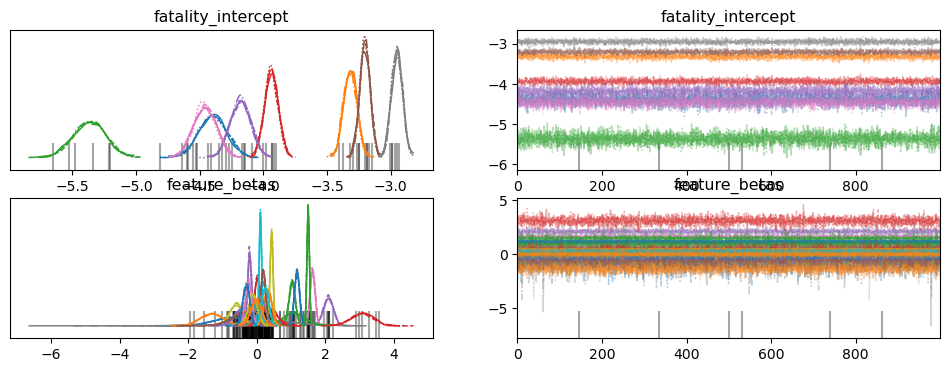

In [128]:
az.plot_trace(trace, var_names=["fatality_intercept", "feature_betas"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

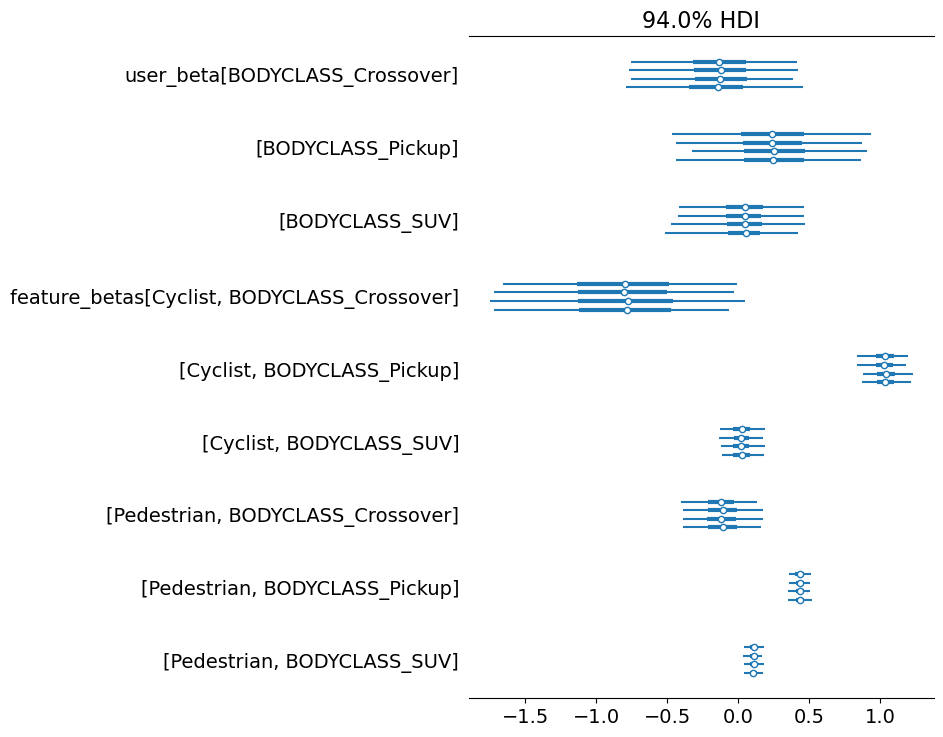

In [129]:
az.plot_forest(trace, var_names=["user_beta", "feature_betas"], combined=False, coords={"feature": ["BODYCLASS_Crossover", "BODYCLASS_Pickup", "BODYCLASS_SUV"]})

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

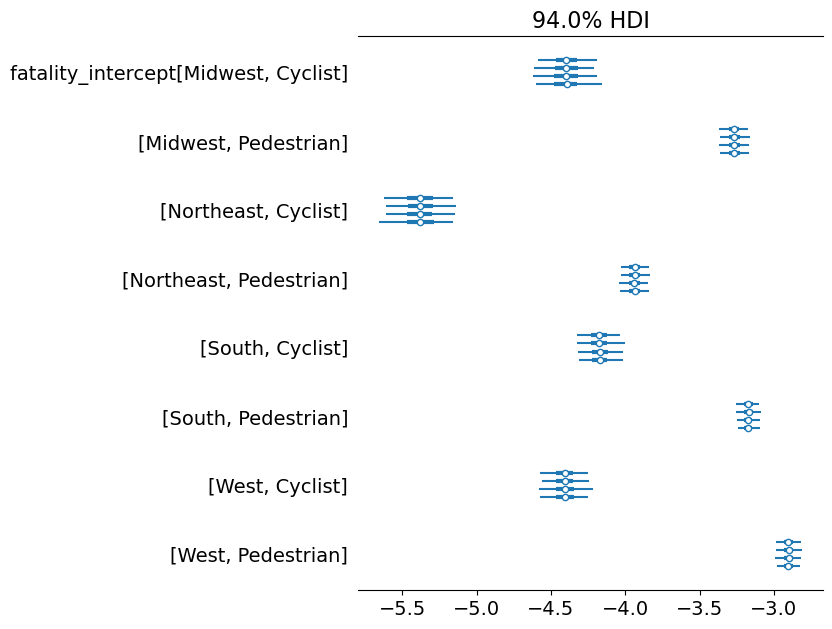

In [28]:
# az.summary(trace.posterior, var_names="fatality_intercept")
az.plot_forest(trace, var_names="fatality_intercept")